In [2]:
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
import numpy
from numpy import array
from numpy import argmax
from tensorflow.keras.models import load_model
from glob import glob
import mne
from sklearn.preprocessing import StandardScaler
import numpy as np

In [3]:

model_paths = ["../model/client_model{}.h5".format(i) for i in range(10)]
models = [load_model(model_path) for model_path in model_paths]

In [4]:
len(models)

10

In [5]:
all_files_path=glob('../test/*.edf')
print(len(all_files_path))
healthy_file_path=[i for i in all_files_path if  'H' in i.split('\\')[1]]
patient_file_path=[i for i in all_files_path if  'M' in i.split('\\')[1]]

print(len(healthy_file_path),len(patient_file_path))
def read_data(file_path):
    raw = mne.io.read_raw_edf(file_path, preload=True)
    # Select a specific channel
    channel_to_keep = ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE']  
      
    # Replace with the name of the channel you want to keep
    raw.pick_channels(channel_to_keep)
    raw.set_eeg_reference()
    raw.filter(l_freq=30,h_freq=100)#1-4=delta, 4-8=theta, 8-12=alpha, 12-30=beta, 30-100=gamma
    epochs=mne.make_fixed_length_epochs(raw,duration=15,overlap=1)
    epochs=epochs.get_data()
    scaler = StandardScaler()
    data = scaler.fit_transform(epochs.reshape(-1,epochs.shape[-1])).reshape(epochs.shape)
    return data #trials,channel,length

18
9 9


In [6]:
%%capture
control_epochs_array=[read_data(subject) for subject in healthy_file_path]
patients_epochs_array=[read_data(subject) for subject in patient_file_path]

In [51]:
control_epochs_labels=[len(i)*[0] for i in control_epochs_array]
patients_epochs_labels=[len(i)*[1] for i in patients_epochs_array]
print(len(control_epochs_labels),len(patients_epochs_labels))
data_list=control_epochs_array+patients_epochs_array
label_list=control_epochs_labels+patients_epochs_labels
print(len(data_list),len(label_list))
data_array=np.vstack(data_list)
label_array=np.hstack(label_list)
data_array=np.moveaxis(data_array,1,2)

9 9
18 18


In [55]:

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = array(yhats)
	# sum across ensemble members
	summed = numpy.sum(yhats, axis=0)
	# argmax across classes
	result = argmax(summed, axis=1)
	
	return result

In [53]:
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
	# select a subset of members
	subset = members[:n_members]
	# make prediction
	yhat = ensemble_predictions(subset, testX)
	# calculate accuracy
	
	return accuracy_score(testy, yhat)


In [59]:
# evaluate different numbers of ensembles on hold out set
single_scores=[]
ensemble_scores = []
for i in range(1,len(models)+1):
	# evaluate model with i members
	ensemble_score = evaluate_n_members(models, i, data_array, label_array)
	# evaluate the i'th model standalone
	testy_enc = to_categorical(label_array)
	single_score = models[i-1].evaluate(data_array, label_array)
	# summarize this step
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score[1], ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score[1])
	
	
# summarize average accuracy of a single final model
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))


17/17 [==============================] - 0s 23ms/step - loss: 4.4785 - Accuracy: 0.4733 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5472
> 1: single=0.473, ensemble=0.473
17/17 [==============================] - 0s 21ms/step - loss: 4.8018 - Accuracy: 0.4733 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5437
> 2: single=0.473, ensemble=0.473
17/17 [==============================] - 0s 22ms/step - loss: 5.2119 - Accuracy: 0.4733 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5420
> 3: single=0.473, ensemble=0.473
17/17 [==============================] - 0s 20ms/step - loss: 4.9752 - Accuracy: 0.4733 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5402
> 4: single=0.473, ensemble=0.473
17/17 [==============================] - 0s 20ms/step - loss: 1.8783 - Accuracy: 0.7753 - precision: 0.7181 - recall: 0.9441 - auc: 0.7825    
> 5: single=0.775, ensemble=0.473
17/17 [==============================] - 0s 20ms/step - loss: 5.9335 - Accuracy: 0.5267 - precision

In [60]:
single_scores

[0.47329649329185486,
 0.47329649329185486,
 0.47329649329185486,
 0.47329649329185486,
 0.7753222584724426,
 0.5267034769058228,
 0.5267034769058228,
 0.5267034769058228,
 0.5267034769058228,
 0.5267034769058228]

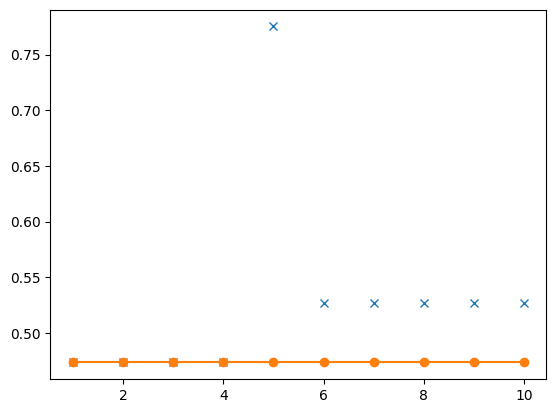

In [61]:
# plot score vs number of ensemble members
x_axis = [i for i in range(1,len(models)+1)]
pyplot.plot(x_axis, single_scores, marker='x', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()